# Extra installs

In [4]:
#!pip install cloud-tpu-client==0.10 torch==1.13.0 https://storage.googleapis.com/tpu-pytorch/wheels/colab/torch_xla-1.13-cp38-cp38-linux_x86_64.whl
!pip install torchsummary 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Imports

In [2]:
import os
import time
import torch.nn as nn
from tqdm import tqdm
import pyarrow.parquet as pq
from collections import defaultdict, Counter
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision.datasets.folder import DatasetFolder
# imports the torch_xla package
from sklearn.metrics import roc_auc_score
import torch.nn.functional as F
from torchsummary import summary
import torch.optim as pt_optim
import torch.optim.lr_scheduler as pt_lr_scheduler

# Dataset

In [3]:
try:
  import google.colab
  COLAB_ENV = True
except:
  COLAB_ENV = False


if COLAB_ENV:
  data_filepath = "/" + os.path.join("content","drive","MyDrive","datasets", "ML4SCI_GSOC23")
  from google.colab import drive
  drive.mount('/content/drive')
else:
  data_filepath = "data"

np_images_filepath = os.path.join(data_filepath, "Task2")
class_to_label = {0 : "Gluon",
                  1 : "Quark"}

model_save_folder = os.path.join(data_filepath, "models", "Task2")

os.makedirs(model_save_folder, exist_ok=True)
print(os.listdir(np_images_filepath))

Mounted at /content/drive
['Gluon', 'Quark']


# EDA

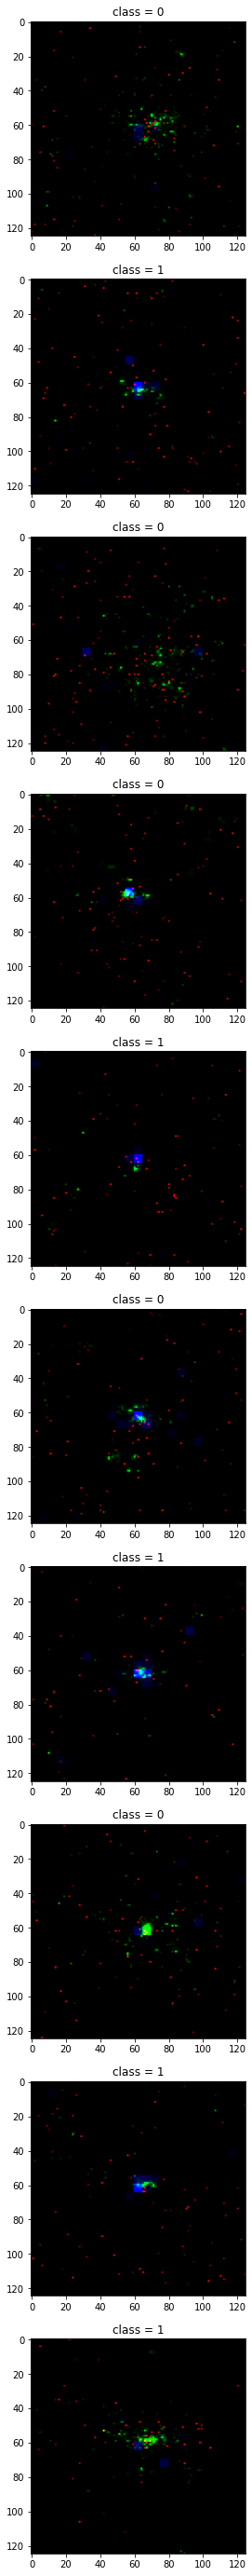

In [5]:
def get_n_random_from_class(_class : int, n : int) -> list:
  class_filepath = os.path.join(np_images_filepath, class_to_label[_class])
  files = [os.path.join(class_filepath, f) for f in os.listdir(class_filepath)]
  idxes = np.random.permutation(np.arange(0, len(files)))[:n]

  return [(_class, files[i]) for i in idxes]

gluons = get_n_random_from_class(0, 5)
quarks = get_n_random_from_class(1, 5)

to_viz = gluons + quarks
np.random.shuffle(to_viz)

scale = 5
n = len(to_viz)
plt.figure(figsize=(scale, n* scale))
for i, datapoint in enumerate(to_viz):
  cls = datapoint[0]
  img = np.load(datapoint[1])
  plt.subplot(n, 1, i + 1)
  plt.imshow(img.transpose(1, 2, 0))
  plt.title(f"class = {cls}")

plt.show()

# Pytorch Dataset Creation

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Device Used : {device}")

Device Used : cuda:0


In [7]:
from torch.utils.data import DataLoader

def load_npy(path : str) -> torch.Tensor:
    return torch.from_numpy(np.load(path))

train_ds = DatasetFolder(np_images_filepath, extensions=[".npy"], loader=load_npy)
train_dl = DataLoader(train_ds, batch_size=32)

In [8]:
next(iter(train_dl))[0].shape

torch.Size([32, 3, 125, 125])

# Test Run

In [16]:
def training_epoch(model, criterion, optimizer, scheduler, dataloader, dataset_size, saveTo, num_epochs=25):
    since = time.time()

    returnDict = {"trainingLoss" : [], "trainingAccuracy" : [], "epochs" : [], "trainingAUC" : []}
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        returnDict["epochs"].append(epoch)

        since2 = time.time()
        model.train()  # Set model to training mode

        running_loss = 0.0
        running_corrects = 0
        y = torch.Tensor()
        pred_y = torch.Tensor()

        i = 0
        # Iterate over data.
        for inputs, labels in dataloader:
            print(f"batch : {i}")
            i += 1
            inputs = inputs.to(device).float()
            labels = labels.to(device)
            labels = labels.long()

            y = torch.cat([y, labels.cpu()])
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                pred_labels = (outputs >= 0.5).reshape(-1)

                #print(outputs.shape)
                loss = criterion(outputs, labels.reshape(-1, 1).to(torch.float32))

                pred_y = torch.cat([pred_y, outputs.cpu()])

                # backward + optimize only if in training phase
                loss.backward()
                optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(pred_labels == labels.data)
            
        scheduler.step()

        epoch_loss = running_loss / dataset_size
        epoch_acc = running_corrects.double() / dataset_size
        AUC_ROC = roc_auc_score(y.detach().numpy(), pred_y.detach().numpy())  

        returnDict["trainingLoss"].append(epoch_loss)
        returnDict["trainingAccuracy"].append(epoch_acc.cpu().item())
        returnDict["trainingAUC"].append(AUC_ROC)

        print(f'Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} AUC ROC : {AUC_ROC:.4f} Time taken : {round(time.time() - since2, 2)}')
        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

    # load best model weights
    returnDict["best_model"] = model
    return returnDict


In [17]:
import torch.nn as nn

class startingModel(nn.Module):
    def __init__(self):
        super(startingModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 5, bias=False)       # output becomes 26x26
        self.conv1_bn = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 64, 5, bias=False)      # output becomes 24x24
        self.conv2_bn = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(2)
      
        self.conv3 = nn.Conv2d(64, 64, 5, bias=False)      # output becomes 22x22
        self.conv3_bn = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, 5, bias=False)      # output becomes 20x20
        self.conv4_bn = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2)

        self.conv5 = nn.Conv2d(64, 64, 5, bias=False)      # output becomes 22x22
        self.conv5_bn = nn.BatchNorm2d(64)
        self.conv6 = nn.Conv2d(64, 64, 5, bias=False)      # output becomes 20x20
        self.conv6_bn = nn.BatchNorm2d(64)
        self.pool3 = nn.MaxPool2d(2)

        self.fc1 = nn.Linear(4096, 64, bias=False)
        self.fc2 = nn.Linear(64, 1, bias=False)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        conv1 = F.relu(self.conv1_bn(self.conv1(x)))
        conv2 = F.relu(self.conv2_bn(self.conv2(conv1)))
        conv2 = self.pool1(conv2)

        conv3 = F.relu(self.conv3_bn(self.conv3(conv2)))
        conv4 = F.relu(self.conv4_bn(self.conv4(conv3)))
        conv4 = self.pool2(conv4)

        conv5 = F.relu(self.conv5_bn(self.conv5(conv4)))
        conv6 = F.relu(self.conv6_bn(self.conv6(conv5)))
        conv6 = self.pool3(conv6)

        flat1 = torch.flatten(conv6.permute(0, 2, 3, 1), 1)
        fc1 = F.relu(self.fc1(flat1))
        logits = self.fc2(fc1)
        return self.sigmoid(logits)

model_ft = startingModel()
summary(model_ft, input_size=(3, 125, 125), device="cpu")
model_ft = model_ft.to(device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 121, 121]           4,800
       BatchNorm2d-2         [-1, 64, 121, 121]             128
            Conv2d-3         [-1, 64, 117, 117]         102,400
       BatchNorm2d-4         [-1, 64, 117, 117]             128
         MaxPool2d-5           [-1, 64, 58, 58]               0
            Conv2d-6           [-1, 64, 54, 54]         102,400
       BatchNorm2d-7           [-1, 64, 54, 54]             128
            Conv2d-8           [-1, 64, 50, 50]         102,400
       BatchNorm2d-9           [-1, 64, 50, 50]             128
        MaxPool2d-10           [-1, 64, 25, 25]               0
           Conv2d-11           [-1, 64, 21, 21]         102,400
      BatchNorm2d-12           [-1, 64, 21, 21]             128
           Conv2d-13           [-1, 64, 17, 17]         102,400
      BatchNorm2d-14           [-1, 64,

In [18]:
optim = pt_optim.Adam(model_ft.parameters())
lr_sched = pt_lr_scheduler.StepLR(optim, 10, 0.9)

training_epoch(model_ft, F.binary_cross_entropy, optim, lr_sched, train_dl, len(train_ds) , os.path.join(model_save_folder, "Simple.pt"), num_epochs=10)

Epoch 0/9
----------
batch : 0
batch : 1


KeyboardInterrupt: ignored